# Predicting hospital admission at emergency department triage using machine learning.
## Prediction Evaluation with: CatBoost
CatBoost is a strong choice for predicting hospital admissions at emergency department triage due to its ability to handle categorical data efficiently, deliver high accuracy, and require minimal parameter tuning. It also offers tools for understanding feature importance, making it suitable for gaining insights in healthcare settings. Additionally, CatBoost is optimized for speed and robustness, which is crucial for handling large datasets and ensuring reliable predictions in critical environments.

In [1]:
!pip install catboost

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import datetime
import seaborn as sns
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD


In [3]:
import pandas as pd
# Load  dataset
data = pd.read_csv('./admission.csv')

# Train and evaluate the model with a specified number of components=200 for SVD

Start Time: 2024-10-27 08:48:23.502684
Machine Learning Model: CatBoost Classifier
Hyperparameters:
  iterations: 300
  depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bylevel: 0.8
  eval_metric: Logloss
  random_state: 42

Accuracy: 0.8460454245392425
Precision: 0.8547839541811968
Confusion Matrix:
[[20814 12576]
 [ 4682 74026]]
AUROC: 0.9004800820538307
Sensitivity/Recall: 0.9405143060425878
Specificity: 0.623360287511231
F1 Score: 0.8956022019236586
Accuracy Interpretability Index: 0.8320612348395832


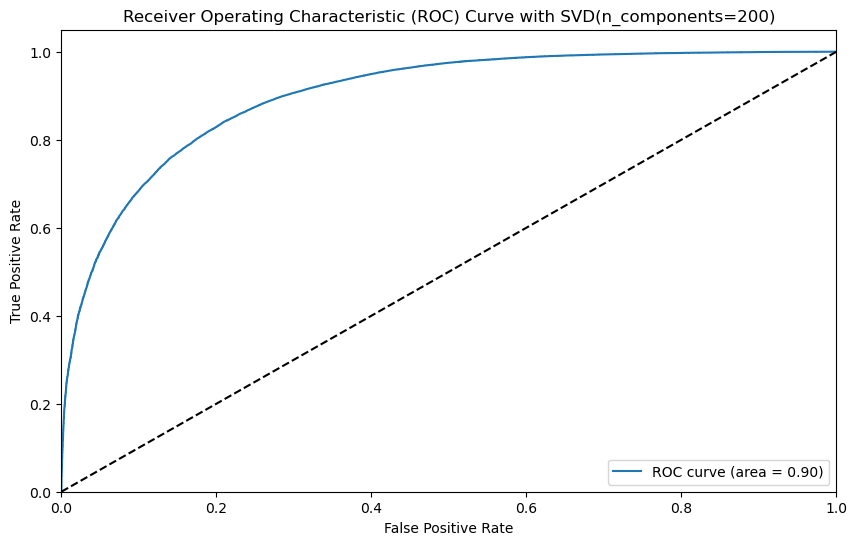

End Time: 2024-10-27 08:50:28.260585
Duration: 0:02:04.757901


In [4]:
# Record the start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")



# Separate features and target variable
X = data.drop(columns=['disposition'])
y = data['disposition']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer to handle categorical and numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())  # Normalize the data
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical data
        ]), categorical_cols)
    ])

# Function to evaluate model with different SVD components
def evaluate_svd(n_components):
    # Create a pipeline to preprocess and apply SVD
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('svd', TruncatedSVD(n_components=n_components, random_state=42))  # Adjust the number of components as needed
    ])

    # Fit and transform the data
    X_svd = pipeline.fit_transform(X)

    # Split the SVD-transformed data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_svd, y_encoded, test_size=0.2, random_state=42)

    # Initialize the CatBoost model with predefined hyperparameters
    catboost_model = CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bylevel=0.8,
        eval_metric='Logloss',
        silent=True,
        random_state=42
    )

    # Fit the CatBoost model
    catboost_model.fit(X_train, y_train)

    # Print the machine learning model and hyperparameters used
    print("Machine Learning Model: CatBoost Classifier")
    print("Hyperparameters:")
    print(f"  iterations: {catboost_model.get_params()['iterations']}")
    print(f"  depth: {catboost_model.get_params()['depth']}")
    print(f"  learning_rate: {catboost_model.get_params()['learning_rate']}")
    print(f"  subsample: {catboost_model.get_params()['subsample']}")
    print(f"  colsample_bylevel: {catboost_model.get_params()['colsample_bylevel']}")
    print(f"  eval_metric: {catboost_model.get_params()['eval_metric']}")
    print(f"  random_state: {catboost_model.get_params()['random_state']}")

    # Predict and evaluate the model
    y_pred = catboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    interpretability_index = (accuracy + precision + recall + specificity + f1) / 5

    # Print the evaluation metrics in the specified template format
    print(f"\nAccuracy: {accuracy}")
    print(f"Precision: {precision}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"AUROC: {auc}")
    print(f"Sensitivity/Recall: {recall}")
    print(f"Specificity: {specificity}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy Interpretability Index: {interpretability_index}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, catboost_model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve with SVD(n_components={n_components})')
    plt.legend(loc='lower right')
    plt.show()

#     # Bootstrap resampling for confidence intervals
#     n_iterations = 1000
#     metrics = np.zeros((n_iterations, 6))

#     for i in range(n_iterations):
#         # Resample the data
#         X_resampled, y_resampled = resample(X_test, y_test, random_state=i)
#         y_pred_resampled = catboost_model.predict(X_resampled)
#         y_proba_resampled = catboost_model.predict_proba(X_resampled)[:, 1]
#         metrics[i] = calculate_metrics(y_resampled, y_pred_resampled, y_proba_resampled)

#     mean_metrics = np.mean(metrics, axis=0)
#     ci_lower = np.percentile(metrics, 2.5, axis=0)
#     ci_upper = np.percentile(metrics, 97.5, axis=0)

#     metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Specificity']
    
#     for mean, lower, upper, name in zip(mean_metrics, ci_lower, ci_upper, metric_names):
#         print(f'{name}: {mean:.4f} (95% CI: {lower:.4f} - {upper:.4f})')

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    return accuracy, precision, recall, f1, auc, specificity

# Train and evaluate the model with a specified number of components for SVD
evaluate_svd(n_components=200)

 

# Record the end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the duration
duration = end_time - start_time
print(f"Duration: {duration}")

# Train and evaluate the model with a specified number of components=300 for SVD

Start Time: 2024-10-27 08:50:28.280431
Machine Learning Model: CatBoost Classifier
Hyperparameters:
  iterations: 300
  depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bylevel: 0.8
  eval_metric: Logloss
  random_state: 42

Accuracy: 0.8473746186372638
Precision: 0.8559031188250384
Confusion Matrix:
[[20920 12470]
 [ 4639 74069]]
AUROC: 0.9017770284113591
Sensitivity/Recall: 0.9410606291609493
Specificity: 0.6265348906858341
F1 Score: 0.8964640810423186
Accuracy Interpretability Index: 0.8334674676702809


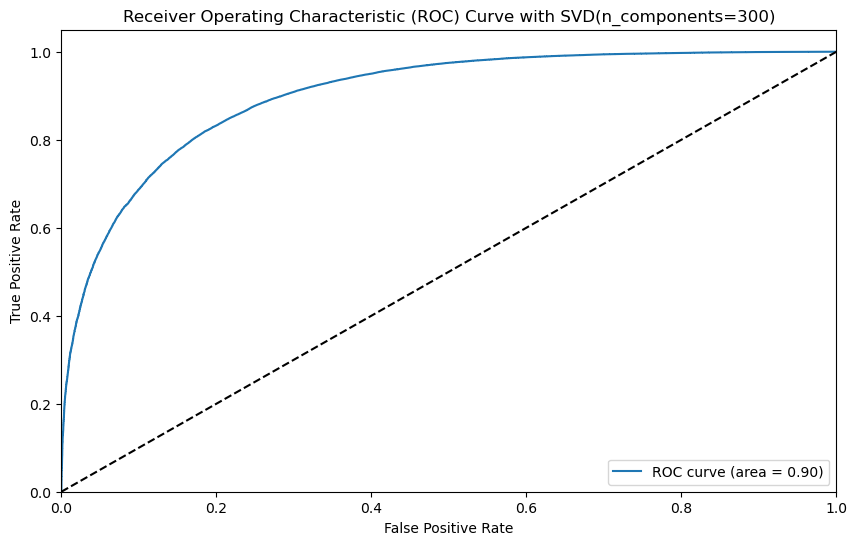

End Time: 2024-10-27 10:07:54.093207
Duration: 1:17:25.812776


In [5]:
# Record the start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")



# Separate features and target variable
X = data.drop(columns=['disposition'])
y = data['disposition']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer to handle categorical and numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())  # Normalize the data
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical data
        ]), categorical_cols)
    ])

# Function to evaluate model with different SVD components
def evaluate_svd(n_components):
    # Create a pipeline to preprocess and apply SVD
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('svd', TruncatedSVD(n_components=n_components, random_state=42))  # Adjust the number of components as needed
    ])

    # Fit and transform the data
    X_svd = pipeline.fit_transform(X)

    # Split the SVD-transformed data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_svd, y_encoded, test_size=0.2, random_state=42)

    # Initialize the CatBoost model with predefined hyperparameters
    catboost_model = CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bylevel=0.8,
        eval_metric='Logloss',
        silent=True,
        random_state=42
    )

    # Fit the CatBoost model
    catboost_model.fit(X_train, y_train)

    # Print the machine learning model and hyperparameters used
    print("Machine Learning Model: CatBoost Classifier")
    print("Hyperparameters:")
    print(f"  iterations: {catboost_model.get_params()['iterations']}")
    print(f"  depth: {catboost_model.get_params()['depth']}")
    print(f"  learning_rate: {catboost_model.get_params()['learning_rate']}")
    print(f"  subsample: {catboost_model.get_params()['subsample']}")
    print(f"  colsample_bylevel: {catboost_model.get_params()['colsample_bylevel']}")
    print(f"  eval_metric: {catboost_model.get_params()['eval_metric']}")
    print(f"  random_state: {catboost_model.get_params()['random_state']}")

    # Predict and evaluate the model
    y_pred = catboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    interpretability_index = (accuracy + precision + recall + specificity + f1) / 5

    # Print the evaluation metrics in the specified template format
    print(f"\nAccuracy: {accuracy}")
    print(f"Precision: {precision}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"AUROC: {auc}")
    print(f"Sensitivity/Recall: {recall}")
    print(f"Specificity: {specificity}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy Interpretability Index: {interpretability_index}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, catboost_model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve with SVD(n_components={n_components})')
    plt.legend(loc='lower right')
    plt.show()
    

#### thes code block is disabled as it takes several hours to process on 16GB laptop
#     # Bootstrap resampling for confidence intervals
#     n_iterations = 1000
#     metrics = np.zeros((n_iterations, 6))

#     for i in range(n_iterations):
#         # Resample the data
#         X_resampled, y_resampled = resample(X_test, y_test, random_state=i)
#         y_pred_resampled = catboost_model.predict(X_resampled)
#         y_proba_resampled = catboost_model.predict_proba(X_resampled)[:, 1]
#         metrics[i] = calculate_metrics(y_resampled, y_pred_resampled, y_proba_resampled)

#     mean_metrics = np.mean(metrics, axis=0)
#     ci_lower = np.percentile(metrics, 2.5, axis=0)
#     ci_upper = np.percentile(metrics, 97.5, axis=0)

#     metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Specificity']
    
#     for mean, lower, upper, name in zip(mean_metrics, ci_lower, ci_upper, metric_names):
#         print(f'{name}: {mean:.4f} (95% CI: {lower:.4f} - {upper:.4f})')

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    return accuracy, precision, recall, f1, auc, specificity

# Train and evaluate the model with a specified number of components for SVD
evaluate_svd(n_components=300)

 

# Record the end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the duration
duration = end_time - start_time
print(f"Duration: {duration}")

# Train and evaluate the model with all features

Start Time: 2024-10-27 13:37:23.315224
Cross-Validation Results:
Accuracy: 0.5837 (± 0.1673)
Precision: 0.8901 (± 0.1213)
Recall: 0.5463 (± 0.3782)
F1: 0.5615 (± 0.3043)
Roc_auc: 0.6091 (± 0.0988)
Machine Learning Model: CatBoost Classifier
Hyperparameters:
  Available parameters: dict_keys(['verbose', 'random_state'])
  iterations: Not available
  depth: Not available
  learning_rate: Not available
  subsample: Not available
  colsample_bylevel: Not available
  eval_metric: Not available
  random_state: 42

Accuracy: 0.8889810701350604
Precision: 0.8957086722323743
Confusion Matrix:
[[24658  8732]
 [ 3713 74995]]
AUROC: 0.9426884888006292
Sensitivity/Recall: 0.9528256339889211
Specificity: 0.7384845762204253
F1 Score: 0.9233847385107888
Accuracy Interpretability Index: 0.879876938217514


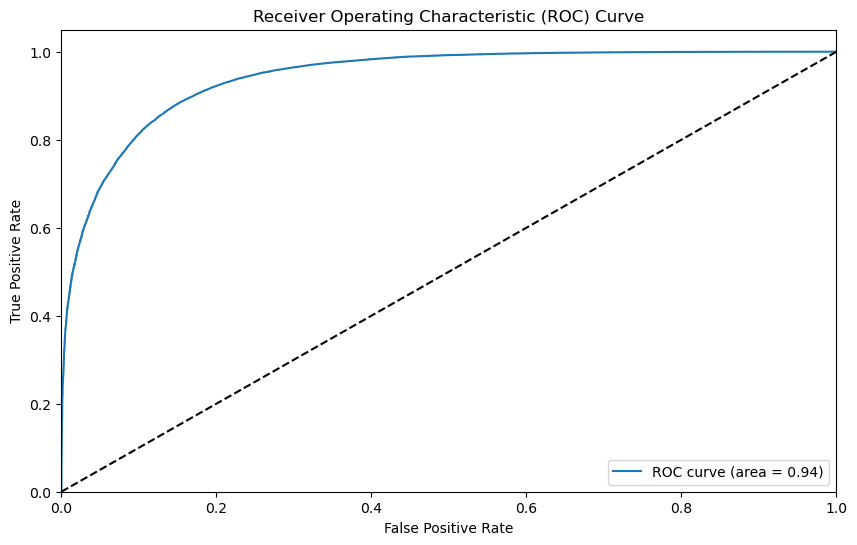

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Record the start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")


# Separate features and target variable
X = data.drop(columns=['disposition'])
y = data['disposition']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer to handle categorical and numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())  # Normalize the data
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical data
        ]), categorical_cols)
    ])

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# # Create a pipeline to preprocess the data and train the CatBoost model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', CatBoostClassifier(verbose=0, random_state=42))
# ])

# # Fit the model
# pipeline.fit(X_train, y_train)


# Create a pipeline to preprocess the data and train the CatBoost model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(verbose=0, random_state=42))
])

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y_encoded, cv=3, scoring=scoring, return_train_score=False)

# Print cross-validation results
print("Cross-Validation Results:")
for metric in scoring.keys():
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean():.4f} (± {cv_results['test_' + metric].std():.4f})")

# Fit the model on the entire training set
pipeline.fit(X, y_encoded)



# Print the machine learning model and hyperparameters used
print("Machine Learning Model: CatBoost Classifier")
print("Hyperparameters:")
params = pipeline.named_steps['classifier'].get_params()
print(f"  Available parameters: {params.keys()}")
print(f"  iterations: {params.get('iterations', 'Not available')}")
print(f"  depth: {params.get('depth', 'Not available')}")
print(f"  learning_rate: {params.get('learning_rate', 'Not available')}")
print(f"  subsample: {params.get('subsample', 'Not available')}")
print(f"  colsample_bylevel: {params.get('colsample_bylevel', 'Not available')}")
print(f"  eval_metric: {params.get('eval_metric', 'Not available')}")
print(f"  random_state: {params.get('random_state', 'Not available')}")




# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
interpretability_index = (accuracy + precision + recall + specificity + f1) / 5

# Print the evaluation metrics in the specified template format
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUROC: {auc}")
print(f"Sensitivity/Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"Accuracy Interpretability Index: {interpretability_index}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    return accuracy, precision, recall, f1, auc, specificity

# Bootstrapping
n_iterations = 1000
metrics = np.zeros((n_iterations, 6))

for i in range(n_iterations):
    # Resample the data
    X_resampled, y_resampled = resample(X_test, y_test, random_state=i)
    y_pred_resampled = pipeline.predict(X_resampled)
    y_proba_resampled = pipeline.predict_proba(X_resampled)[:, 1]

    # Calculate metrics
    metrics[i] = calculate_metrics(y_resampled, y_pred_resampled, y_proba_resampled)

# Calculate mean and 95% confidence intervals
mean_metrics = np.mean(metrics, axis=0)
ci_lower = np.percentile(metrics, 2.5, axis=0)
ci_upper = np.percentile(metrics, 97.5, axis=0)

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Specificity']
for mean, lower, upper, name in zip(mean_metrics, ci_lower, ci_upper, metric_names):
    print(f'{name}: {mean:.4f} (95% CI: {lower:.4f} - {upper:.4f})')

    
    # Record the end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the duration
duration = end_time - start_time
print(f"Duration: {duration}")